<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 3</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37004 IRCRM" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


# Import package


In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.integrate import quad

Suppose that the dynamics of the default-free interest rate term structure are given by a one-factor Gaussian HJM model with volatility parameter $\sigma=0.025$ and mean reversion $a=0.08$. The current term structure is flat at 5\% continuously compounded for all maturities. Suppose further that the CDS spreads (paid annually, in arrears, in basis points) for a corporate entity <B>A</B> are deterministic and given by the following `pandas` dataframe:


In [2]:
import pandas as pd
df = pd.DataFrame([{"Maturity in years":1,"Spread":120},{"Maturity in years":2,"Spread":130},{"Maturity in years":3,"Spread":140},{"Maturity in years":5,"Spread":150},{"Maturity in years":10,"Spread":170}])
df

,Maturity in years,Spread
0,1,120
1,2,130
2,3,140
3,5,150
4,10,170


Assume that default, recovery in default, and default-free interest rates are mutually independent. Expected recovery is 40\%. You may ignore accrued interest in the case of default. You may assume loglinear interpolation of risk-neutral probabilities of survival where necessary.

Entity <B>A</B> approaches a bank of negligible default risk, with the wish of <B>A</B> to enter into a 10-year interest swap, where <B>A</B> pays floating and receives fixed annually, with simple compounding.

<H2>Task 1:</H2>
Taking into account counterparty credit risk, what is the level of the fixed coupon on this swap, which results in a zero initial mark-to-market value of the swap? If some of the above assumptions are relaxed, in which case would the bank be exposed to "wrong-way risk" in this transaction? <I>(5 marks)</I>


In [3]:
def probability_of_survival(df_spread):
    df = pd.DataFrame(df_spread)
    df['Probability of survival'] = np.zeros(len(df_spread))
    r = 0.05
    c = 0.4
    def prob_interpolation(t, index=None, x=None):
        if t == 0:
            return 1
        partial_df = df.iloc[:index+1,:] if index is not None else pd.DataFrame(df)
        if x is not None:
            partial_df.iloc[index, 2] = x
        if t in partial_df.iloc[:,0].values:
            return partial_df[partial_df["Maturity in years"]==t]['Probability of survival'].values[0]
        T1 = max(list(filter(lambda x: x < t, partial_df.iloc[:,0]))+[0])
        T2 = min(list(filter(lambda x: x >= t, partial_df.iloc[:,0])))
        P1 = partial_df[partial_df["Maturity in years"]==T1]['Probability of survival'].values[0] if T1 != 0 else 1
        P2 = partial_df[partial_df["Maturity in years"]==T2]['Probability of survival'].values[0]
        return P1*(P2/P1)**((t-T1)/(T2-T1))
    def probability_survival_solver(x, index):
        sk = df_spread.iloc[index, 1]/10000
        T = df_spread.iloc[index, 0]
        Ts = np.arange(1, T+1)
        Bs = np.array(list(map(lambda t: np.exp(-r*t), Ts)))
        Ps = np.array(list(map(lambda t: prob_interpolation(t, index, x), Ts)))
        return sk*np.sum(Bs*Ps) - (1-c)*np.sum([np.exp(-r*t)*(prob_interpolation(t-1, index, x)-prob_interpolation(t, index, x)) for t in Ts])
    for i in range(len(df_spread)):
        df.iloc[i, 2] = fsolve(probability_survival_solver, 0.5, args=(i))[0]
    print(df)
    return prob_interpolation
prob_calc = probability_of_survival(df)

   Maturity in years  Spread  Probability of survival
0                  1     120                 0.980392
1                  2     130                 0.957919
2                  3     140                 0.932673
3                  5     150                 0.882502
4                 10     170                 0.749129


In [4]:
def task_1(prob_interpolation):
    r = 0.05
    c = 0.4
    T = 10
    Ts = np.arange(1, T+1)
    Bs = np.array(list(map(lambda t: np.exp(-r*t), Ts)))
    omega = (1-Bs[-1])/np.sum(Bs)
    Ps = np.array(list(map(lambda t: prob_interpolation(t), np.arange(0,T+1))))
    Ps_diff = np.diff(Ps[::-1])[::-1][:-1]
    mean_reversion = 0.08
    volatility_level = 0.025

    def bond_calculator(t_trans, T_trans, z=None, ret=None):
        BT = np.exp(-r*T_trans)
        Bt = np.exp(-r*t_trans)
        A = (BT/Bt)*np.exp(-np.exp(-2*(t_trans+T_trans)*mean_reversion)*(np.exp(mean_reversion*t_trans)-1)*(volatility_level**2)*(np.exp(2*mean_reversion*t_trans)+np.exp(3*mean_reversion*t_trans)-np.exp(2*mean_reversion*T_trans)-4*np.exp(mean_reversion*(2*t_trans+T_trans))+3*np.exp(mean_reversion*(t_trans+2*T_trans)))/(4*(mean_reversion**3)))
        B = (np.exp(-mean_reversion*t_trans)-np.exp(-mean_reversion*T_trans))/mean_reversion
        if ret:
            return A,B
        return A*np.exp(-B*z)
    
    def short_rate_solver(z, lk, payments_dates):
        Bs = list(map(lambda x:bond_calculator(payments_dates[0], x, z),payments_dates[1:]))
        BTn = 1-lk*sum(Bs)
        A,B = bond_calculator(payments_dates[0], payments_dates[-1], ret=True)
        return z+np.log(BTn/A)/B

    def bond_option_info_calculator(Ti_trans, z, T0_trans):
        B_star = bond_calculator(T0_trans, Ti_trans, z)
        BTi = np.exp(-r*Ti_trans)
        BT0 = np.exp(-r*T0_trans)
        chi = np.exp(-mean_reversion*Ti_trans)*(volatility_level**2)*(np.exp(mean_reversion*T0_trans)-np.exp(-mean_reversion*T0_trans))*((np.exp(mean_reversion*(T0_trans-Ti_trans)/2)-np.exp(-mean_reversion*(T0_trans-Ti_trans)/2))**2)/(2*(mean_reversion**3))
        h1 = (np.log(BTi/(BT0*B_star))+chi/2)/np.sqrt(chi)
        h2 = (np.log(BTi/(BT0*B_star))-chi/2)/np.sqrt(chi)
        return [BT0*B_star*norm.cdf(-h2)-BTi*norm.cdf(-h1)]
    
    def value_calculator(z, lk, payments_dates):
        bond_info = list(map(lambda x: bond_option_info_calculator(x, z, payments_dates[0]), payments_dates[1:]))
        Cs = list(map(lambda x: x[0], bond_info))
        return Cs[-1]+lk*np.sum(Cs)
    
    def spread_solver(s):
        lk = omega + s[0]
        zs = list(map(lambda x: fsolve(short_rate_solver, 0.1, args=(lk, np.arange(x, T+1)))[0], Ts[:-1]))
        Vs = [value_calculator(zs[x], lk, np.arange(Ts[x], T+1)) for x in range(len(zs))]
        return (1-c)*np.sum(Vs*Ps_diff)+s[0]*sum(Bs)
    spread = fsolve(spread_solver, 0)[0]
    return spread, omega+spread
spread, fixed_rate = task_1(prob_calc)
print('Level of the spread on this swap:',float(spread))
print('Level of the fixed coupon on this swap:',float(fixed_rate))

Level of the spread on this swap: -0.000814374936289219
Level of the fixed coupon on this swap: 0.05045672143973482


As we have:

$$
EE_{t_i} = E_{t_i}[max(0,V_{t_i})] \\
=E_{t_i}[max(0,1-B(t_i,t_N)-l_k \sum_{j=i+1}^{N}B(t_i,t_j))]
$$

Then, the lower the interest payment (the higher the interest rate), the more credit risk exposure of the bank must face. Furthurmore, the right way risk is when the more credit risk exposure, the less it likely to be defaulted. Hence, the negative correlation between the default risk and the interest rate is the right way risk. Since then, the positive correlation between the default risk and the interest rate is the wrong way risk


<H2>Task 2:</H2>
Suppose the bank has an existing swap with the same counterparty, where the bank pays floating and receives fixed annually, with simple compounding. This swap has exactly three years left to run, and the fixed leg was set at 4.75% (simple compounding).

1. In this situation, what is the answer to Task 1 if there is no netting agreement in place? If there is a netting agreement in place? <I>(5 marks)</I>
2. Suppose further that the market price interest rate risk relevant in this context is constant $\sigma_{\hat H}=0.15$. With and without netting, determine the potential future exposure (PFE) for the bank for a one-year time horizon, with 99\% confidence level, just before and just after entering into the 10-year swap with <B>A</B>. What is the impact of the market price of risk on the PFE?
   <I>(5 marks)</I>


In [5]:
def task_2_part_1(prob_interpolation, isNetting):
    r = 0.05
    c = 0.4
    T1 = 10
    T2 = 3
    Ts1 = np.arange(1, T1+1)
    Ts2 = np.arange(1, T2+1)
    Bs = np.array(list(map(lambda t: np.exp(-r*t), Ts1)))
    omega = (1-Bs[-1])/np.sum(Bs)
    prev_rate = 0.0475
    Ps = np.array(list(map(lambda t: prob_interpolation(t), np.arange(0,T1+1))))
    Ps_diff = np.diff(Ps[::-1])[::-1]
    Ps_diff = Ps_diff[:-1]
    mean_reversion = 0.08
    volatility_level = 0.025

    def bond_calculator(t_trans, T_trans, z=None, ret=None):
        BT = np.exp(-r*T_trans)
        Bt = np.exp(-r*t_trans)
        A = (BT/Bt)*np.exp(-np.exp(-2*(t_trans+T_trans)*mean_reversion)*(np.exp(mean_reversion*t_trans)-1)*(volatility_level**2)*(np.exp(2*mean_reversion*t_trans)+np.exp(3*mean_reversion*t_trans)-np.exp(2*mean_reversion*T_trans)-4*np.exp(mean_reversion*(2*t_trans+T_trans))+3*np.exp(mean_reversion*(t_trans+2*T_trans)))/(4*(mean_reversion**3)))
        B = (np.exp(-mean_reversion*t_trans)-np.exp(-mean_reversion*T_trans))/mean_reversion
        if ret:
            return A,B
        return A*np.exp(-B*z)
    
    def short_rate_solver(z, lk, payments_dates, isNetting=False):
        Bs = list(map(lambda x:bond_calculator(payments_dates[0], x, z),payments_dates[1:]))
        Bs = np.array(Bs)
        weight = [lk]*len(Bs)
        weight = np.array(weight)
        BTn = None
        if isNetting:
            if payments_dates[0]==1:
                weight[0] -= prev_rate
                weight[1] -= prev_rate + 1
                BTn = -weight @ Bs
            elif payments_dates[0]==2:
                weight[0] -= prev_rate + 1
                BTn = -weight @ Bs
        else:
            BTn = 1-weight @ Bs
        A,B = bond_calculator(payments_dates[0], payments_dates[-1], ret=True)
        return z+np.log(BTn/A)/B

    def bond_option_info_calculator(Ti_trans, z, T0_trans, isCall):
        B_star = bond_calculator(T0_trans, Ti_trans, z)
        BTi = np.exp(-r*Ti_trans)
        BT0 = np.exp(-r*T0_trans)
        chi = np.exp(-mean_reversion*Ti_trans)*(volatility_level**2)*(np.exp(mean_reversion*T0_trans)-np.exp(-mean_reversion*T0_trans))*((np.exp(mean_reversion*(T0_trans-Ti_trans)/2)-np.exp(-mean_reversion*(T0_trans-Ti_trans)/2))**2)/(2*(mean_reversion**3))
        h1 = (np.log(BTi/(BT0*B_star))+chi/2)/np.sqrt(chi)
        h2 = (np.log(BTi/(BT0*B_star))-chi/2)/np.sqrt(chi)
        if isCall:
            return [BTi*norm.cdf(h1)-BT0*B_star*norm.cdf(h2), B_star]
        else:
            return [BT0*B_star*norm.cdf(-h2)-BTi*norm.cdf(-h1), B_star]
    
    def value_calculator(z, lk, payments_dates, isCall, isNetting=False):
        Cs = list(map(lambda x: bond_option_info_calculator(x, z, payments_dates[0], isCall)[0], payments_dates[1:]))
        Cs = np.array(Cs)
        weight = [lk]*len(Cs)
        if isNetting:
            if payments_dates[0]==1:
                weight[0] -= prev_rate
                weight[1] -= prev_rate + 1
            elif payments_dates[0]==2:
                weight[0] -= prev_rate + 1
        weight[-1] += 1
        weight = np.array(weight)
        return weight.dot(Cs)
    
    def spread_solver_no_netting(s):
        zs = list(map(lambda x: fsolve(short_rate_solver, 0.1, args=(prev_rate, np.arange(x, T2+1)))[0], Ts2[:-1]))
        Vs = [value_calculator(zs[x], prev_rate, np.arange(Ts2[x], T2+1), True) for x in range(len(zs))]
        L2 = (1-c)*np.sum(Vs*Ps_diff[:T2-1])
        lk = omega + s[0]
        zs = list(map(lambda x: fsolve(short_rate_solver, 0.1, args=(lk, np.arange(x, T1+1)))[0], Ts1[:-1]))
        Vs = [value_calculator(zs[x], lk, np.arange(Ts1[x], T1+1), False) for x in range(len(zs))]
        L1 = (1-c)*np.sum(Vs*Ps_diff)
        return L1+L2+s[0]*sum(Bs)
    
    def spread_solver_netting(s):
        lk = omega + s[0]
        zs = list(map(lambda x: fsolve(short_rate_solver, 0.1, args=(lk, np.arange(x, T1+1), True if x<3 else False))[0], Ts1[:-1]))
        Vs = [value_calculator(zs[x], lk, np.arange(Ts1[x], T1+1), False, True) for x in range(len(zs))]
        return (1-c)*np.sum(Vs*Ps_diff)+s[0]*sum(Bs)
    spread = 0
    if isNetting:
        spread = fsolve(spread_solver_netting, -0.5)[0]
    else:
        spread = fsolve(spread_solver_no_netting, -0.5)[0]
    # if isNetting:
    #     lk = omega
    #     zs = np.linspace(-0.05, 1, 100)
    #     Vs = []
    #     for z in zs:
    #         Cs = list(map(lambda x: bond_option_info_calculator(x, z, 1, True)[1], np.arange(2,11)))
    #         Cs = np.array(Cs)
    #         weight = [lk]*len(Cs)
    #         weight[0] -= prev_rate
    #         weight[1] -= prev_rate + 1
    #         weight[-1] += 1
    #         weight = np.array(weight)
    #         Vs.append(-weight.dot(Cs))
    #     plt.figure(figsize=(15, 5))
    #     plt.plot(zs, Vs)
    #     plt.xlabel('z')
    #     plt.ylabel('value')
    #     plt.title('Value of the swap at T1')
    #     plt.grid()
    #     plt.show()
    #     Vs = []
    #     for z in zs:
    #         Cs = list(map(lambda x: bond_option_info_calculator(x, z, 2, True)[1], np.arange(3,11)))
    #         Cs = np.array(Cs)
    #         weight = [lk]*len(Cs)
    #         weight[0] -= prev_rate + 1
    #         weight[-1] += 1
    #         weight = np.array(weight)
    #         Vs.append(-weight.dot(Cs))
    #     plt.figure(figsize=(15, 5))
    #     plt.plot(zs, Vs)
    #     plt.xlabel('z')
    #     plt.ylabel('value')
    #     plt.title('Value of the swap at T2')
    #     plt.grid()
    #     plt.show()
    return spread, omega+spread
spread, fixed_rate_no_net = task_2_part_1(prob_calc, False)
print('Level of the no netting spread on this swap:',float(spread))
print('Level of the no netting fixed coupon on this swap:',float(fixed_rate_no_net))
spread, fixed_rate_netting = task_2_part_1(prob_calc, True)
print('Level of the netting spread on this swap:',float(spread))
print('Level of the netting fixed coupon on this swap:',float(fixed_rate_netting))

Level of the no netting spread on this swap: -0.0008531057862734287
Level of the no netting fixed coupon on this swap: 0.05041799058975061
Level of the netting spread on this swap: -0.0007593511806403688
Level of the netting fixed coupon on this swap: 0.05051174519538367


In [8]:
def task_2_part_2(fixed_rate=None, isNetting=False, sigma_H = 0.15):
    r = 0.05
    T1 = 10
    T2 = 3
    alpha = 1-0.99
    prev_rate = 0.0475
    mean_reversion = 0.08
    volatility_level = 0.025

    def bond_threshold(Ti_trans, T0_trans, isPayer):
        BTi = np.exp(-r*Ti_trans)
        BT0 = np.exp(-r*T0_trans)
        # chi = np.exp(-mean_reversion*Ti_trans)*(volatility_level**2)*(np.exp(mean_reversion*T0_trans)-np.exp(-mean_reversion*T0_trans))*((np.exp(mean_reversion*(T0_trans-Ti_trans)/2)-np.exp(-mean_reversion*(T0_trans-Ti_trans)/2))**2)/(2*(mean_reversion**3))
        chi = (-1+np.exp(2*mean_reversion*T0_trans))*((np.exp(-mean_reversion*T0_trans)-np.exp(-mean_reversion*Ti_trans))**2)*(volatility_level**2)/(2*mean_reversion**3)
        chi_trans = np.exp(-mean_reversion*(2*T0_trans+Ti_trans))*(-1+np.exp(mean_reversion*T0_trans))*(np.exp(mean_reversion*T0_trans)-np.exp(mean_reversion*Ti_trans))*volatility_level*(-volatility_level+np.exp(mean_reversion*T0_trans)*(volatility_level+2*mean_reversion*sigma_H))/(2*mean_reversion**3)
        return (BTi/BT0)*np.exp(chi_trans-0.5*chi+norm.ppf(1-alpha if isPayer else alpha)*np.sqrt(chi))

    B_threshold = list(map(lambda x: bond_threshold(x ,1, True), np.arange(2,T2+1)))
    swap_rate = (1-B_threshold[-1])/sum(B_threshold)
    PFE1 = (prev_rate-swap_rate)*sum(B_threshold)
    if fixed_rate is None:
        return PFE1
    B_threshold = list(map(lambda x: bond_threshold(x, 1, False), np.arange(2,T1+1)))
    swap_rate = (1-B_threshold[-1])/sum(B_threshold)
    PFE2 = (swap_rate-fixed_rate)*sum(B_threshold)
    if isNetting:
        B_threshold = list(map(lambda x: bond_threshold(x ,1, False), np.arange(2,T2+1)))
        swap_rate = (1-B_threshold[-1])/sum(B_threshold)
        PFE1 = (prev_rate-swap_rate)*sum(B_threshold)
        return PFE1+PFE2
    else:
        return max(PFE1,PFE2)
print('PFE of before entering swap:',float(task_2_part_2()))
print('PFE of the no netting after entering swap:',float(task_2_part_2(fixed_rate_no_net, False)))
print('PFE of the netting after entering swap:',float(task_2_part_2(fixed_rate_netting, True)))

PFE of before entering swap: 0.08991747512787018
PFE of the no netting after entering swap: 0.28499445970802284
PFE of the netting after entering swap: 0.1749174808649816


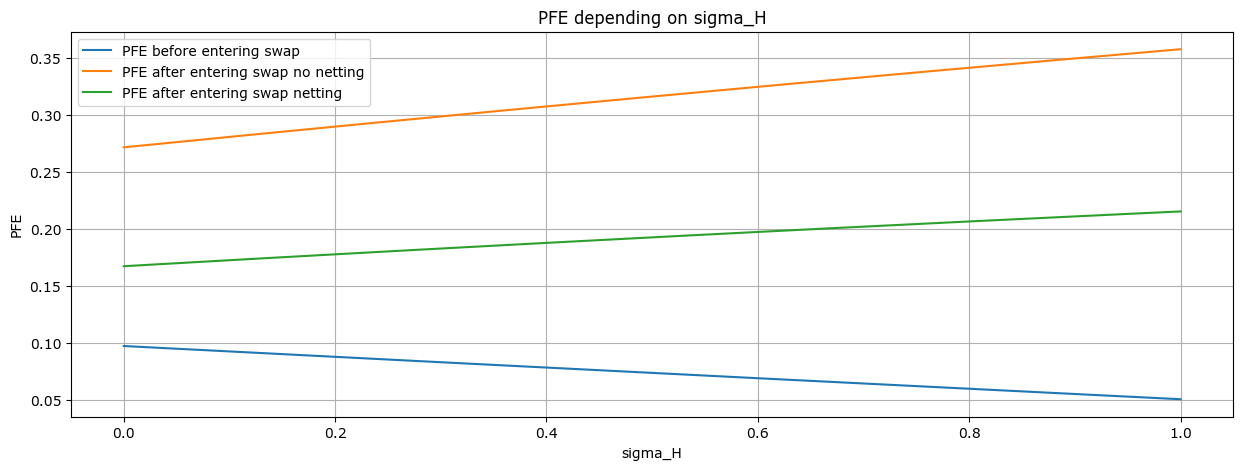

In [7]:
sigma_Hs = np.linspace(0, 1, 1000)
PFE_before = list(map(lambda x: task_2_part_2(sigma_H=x), sigma_Hs))
PFE_after_no_net = list(map(lambda x: task_2_part_2(fixed_rate_no_net, False, x), sigma_Hs))
PFE_after_net = list(map(lambda x: task_2_part_2(fixed_rate_netting, True, x), sigma_Hs))
plt.figure(figsize=(15, 5))
plt.plot(sigma_Hs, PFE_before, label='PFE before entering swap')
plt.plot(sigma_Hs, PFE_after_no_net, label='PFE after entering swap no netting')
plt.plot(sigma_Hs, PFE_after_net, label='PFE after entering swap netting')
plt.xlabel('sigma_H')
plt.ylabel('PFE')
plt.title('PFE depending on sigma_H')
plt.legend()
plt.grid()
plt.show()

When increasing the $\sigma_H$, the mean of the bonds decrease, which increase the value of the floating payments.

- In the case before entering into a new swap, the bank is in the position in which it is required to pay float. Since the value of the float increase, the value of the swap with respect to the bank is decrease, which decrease the potential future exposure to the credit risk.
- In the case after entering into a new swap with no netting, the bank is in the position in which it is required to pay float for the old swap and receive float from the new swap. Since the value of the PFE of the new swap tends to be higher the value of the PFE of the old swap, the PFE of the bank tends to be influenced by the new swap, which in the position of receiving float. Since then, when the float increase, the value of the swap with respect to the bank is increase, which increase the potential future exposure to the credit risk.
- In the case after entering into a new swap with netting, the banks floating position is receiving (from 4 years from now to maturity). Since then, when the float increase, the value of the swap with respect to the bank is increase, which increase the potential future exposure to the credit risk.